In [1]:
import numpy as np
import matplotlib.pyplot as plt
from simulation_functions import *
from tqdm import tqdm
from scipy.integrate import solve_ivp

In [5]:
k = np.genfromtxt('killer_results/k_killer.csv', delimiter=',')
K = np.genfromtxt('killer_results/KK_killer.csv', delimiter=',')
lam_c = np.genfromtxt('killer_results/lam_c_killer.csv', delimiter=',')
s_hat = np.genfromtxt('killer_results/s_hat_killer.csv', delimiter=',')

In [68]:
def sim_dyn(n0,t_f,k,K,lam):
    def dndt(t,n):
        output = calc_dndt(k,K,n,lam)
        return output
    t_span = [0, t_f]  # Time span to solve the differential equation
    rtol = 1e-6  # Relative tolerance for the solution
    atol = 1e-9  # Absolute tolerance for the solution
    sol = solve_ivp(dndt, t_span, n0, rtol=rtol, atol=atol, dense_output=True, method='Radau')

    # Create an interpolating function for the solution
    sol_fun = sol.sol

    # Evaluate the solution at a large number of time points for plotting
    t_eval = np.linspace(t_span[0], t_span[1], 1000)
    n_eval = sol_fun(t_eval)
    return n_eval, t_eval

In [10]:
def n_f_dist(n_f,n_p):
    return np.sqrt(np.sum((n_p-n_f)**2))/np.linalg.norm(n_f)

In [20]:
def calc_dndt_controlled(k,K,n,n_f,lam,lam_p,lam_c,s_hat):
    s = np.dot(s_hat,n - n_f)
    return np.matmul(k*(np.outer(np.ones(len(n)),n)+ K)**(-1),n) - lam*n - lam_p*n - s*lam_c*n

In [21]:
def sim_dyn_controlled(n0,t_f,k,K,n_f,lam,lam_p,lam_c,s_hat):
    def dndt(t,n):
        output = calc_dndt_controlled(k,K,n,n_f,lam,lam_p,lam_c,s_hat)
        return output
    t_span = [0, t_f]  # Time span to solve the differential equation
    rtol = 1e-6  # Relative tolerance for the solution
    atol = 1e-9  # Absolute tolerance for the solution
    sol = solve_ivp(dndt, t_span, n0, rtol=rtol, atol=atol, dense_output=True, method='Radau')

    # Create an interpolating function for the solution
    sol_fun = sol.sol

    # Evaluate the solution at a large number of time points for plotting
    t_eval = np.linspace(t_span[0], t_span[1], 1000)
    n_eval = sol_fun(t_eval)
    return n_eval, t_eval

In [43]:
def plot_eigenvectors(v,nt,n_f):
    for i in range(1):
        v_plot = np.dot(v[:,i],nt)
        n_f_v = np.dot(v[:,i],n_f)
        #v_plot = v_plot - v_plot[-1]
        v_plot = v_plot - n_f_v
        if i == 0:
            plt.plot(t,v_plot,'--',label = 'Slow Mode')
            plt.legend()
        else:
            plt.plot(t,v_plot)

In [16]:
t_f = 200
g = 30
lam = 5
n0 = np.zeros(g) + 0.5
nt, t = sim_dyn(n0,t_f)
n_f = nt[:,-1]

In [17]:
J = calc_J(k,K,n_f,lam)
w, v = np.linalg.eig(J)

/Users/christopher/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/Users/christopher/opt/anaconda3/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


(array([2., 4., 6., 4., 4., 5., 2., 2., 0., 1.]),
 array([-6.6501887 +0.j, -6.23388745+0.j, -5.8175862 +0.j, -5.40128495+0.j,
        -4.9849837 +0.j, -4.56868245+0.j, -4.1523812 +0.j, -3.73607995+0.j,
        -3.3197787 +0.j, -2.90347745+0.j, -2.4871762 +0.j]),
 <BarContainer object of 10 artists>)

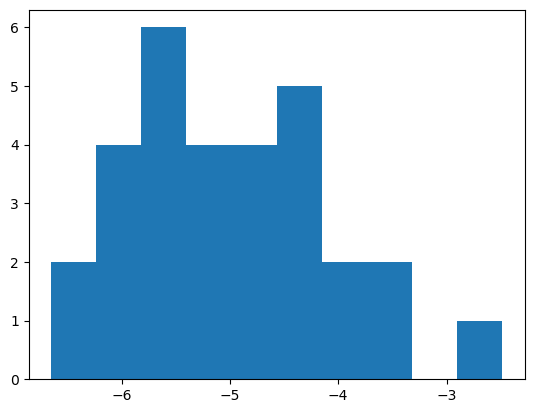

In [19]:
plt.hist(w)

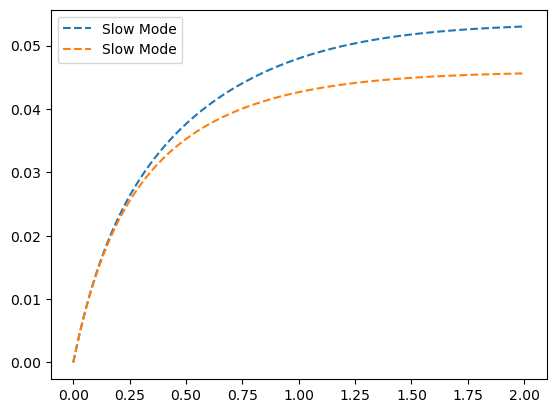

In [51]:
t_f = 2
lam_p = np.zeros(g) 
i =20
lam_p[i] = lam_p[i]+2
nt, t = sim_dyn_controlled(n_f,t_f,k,K,n_f,lam,lam_p,lam_c,s_hat)
plot_eigenvectors(v,nt,n_f)
nt, t = sim_dyn_controlled(n_f,t_f,k,K,n_f,lam,lam_p,np.zeros(g),s_hat)
plot_eigenvectors(v,nt,n_f)

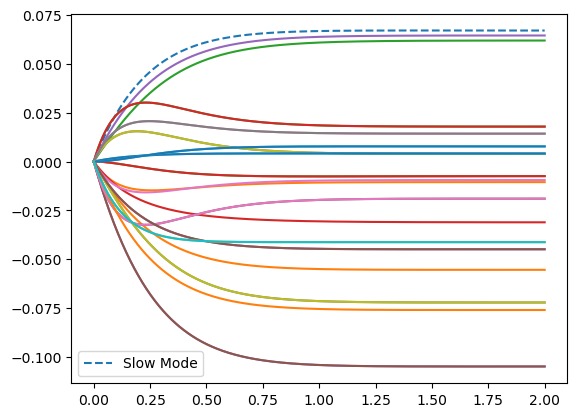

In [34]:
plot_eigenvectors(v,nt,n_f)

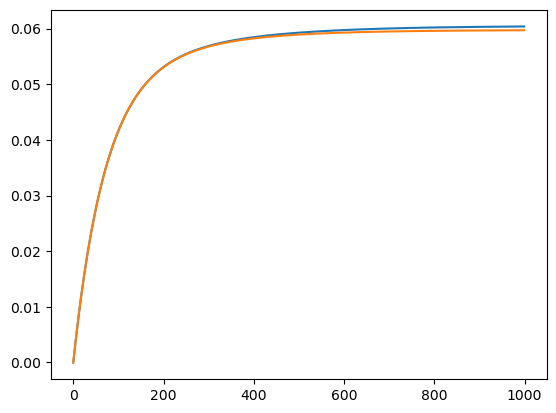

In [60]:
t_f = 2
lam_p = np.zeros(g) 
i =20
lam_p[i] = lam_p[i]+2
nt, t = sim_dyn_controlled(n_f,t_f,k,K,n_f,lam,lam_p,lam_c,s_hat)
plt.plot([n_f_dist(n_f,nt[:,i]) for i in range(len(nt[0,:]))])
nt, t = sim_dyn_controlled(n_f,t_f,k,K,n_f,lam,lam_p,np.zeros(g),s_hat)
plt.plot([n_f_dist(n_f,nt[:,i]) for i in range(len(nt[0,:]))])

In [70]:
evolved_gap = np.sort(w)[-1]/np.sort(w)[-2]
gaps = []

In [71]:
for i in tqdm(range(1000)):    
    g = 30
    lam = 5
    lam = np.zeros(g)+lam
    is_connected = np.random.rand(g,g) < .25
    is_connected = np.tril(is_connected, k=-1)
    is_connected = is_connected + np.transpose(is_connected)
    k = np.multiply(is_connected,np.random.rand(g,g))
    K = np.multiply(is_connected,np.random.rand(g,g))
    t_f = 200
    n0 = np.zeros(g) + 0.5
    nt, t = sim_dyn(n0,t_f,k,K,lam)
    n_f = nt[:,-1]
    J = calc_J(k,K,n_f,lam)
    w, v = np.linalg.eig(J)
    gaps.append(np.sort(w)[-1]/np.sort(w)[-2])

100%|███████████████████████████████████████| 1000/1000 [00:29<00:00, 34.03it/s]


(array([ 1.,  2.,  0.,  2.,  4.,  2.,  3.,  2.,  3.,  9.,  6., 11., 11.,
        14., 19., 17., 26., 20., 40., 35., 53., 59., 59., 64., 61., 42.,
        56., 46., 48., 51., 48., 31., 32., 28., 26., 22., 15., 11.,  5.,
         3.,  3.,  3.,  3.,  0.,  3.,  0.,  0.,  0.,  0.,  1.]),
 array([0.60465197+0.01937839j, 0.60973834+0.01899082j,
        0.61482472+0.01860325j, 0.6199111 +0.01821568j,
        0.62499748+0.01782812j, 0.63008386+0.01744055j,
        0.63517023+0.01705298j, 0.64025661+0.01666541j,
        0.64534299+0.01627785j, 0.65042937+0.01589028j,
        0.65551575+0.01550271j, 0.66060212+0.01511514j,
        0.6656885 +0.01472757j, 0.67077488+0.01434001j,
        0.67586126+0.01395244j, 0.68094764+0.01356487j,
        0.68603401+0.0131773j , 0.69112039+0.01278974j,
        0.69620677+0.01240217j, 0.70129315+0.0120146j ,
        0.70637953+0.01162703j, 0.7114659 +0.01123946j,
        0.71655228+0.0108519j , 0.72163866+0.01046433j,
        0.72672504+0.01007676j, 0.73181142+0

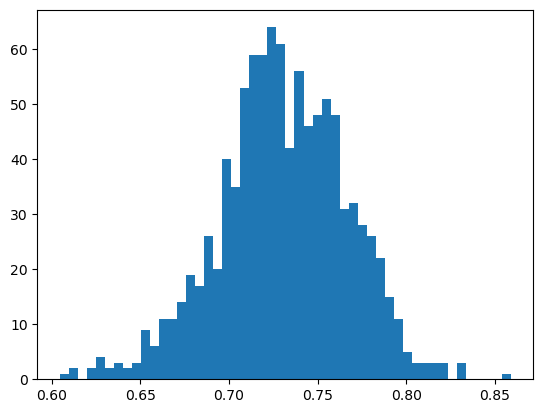

In [73]:
plt.hist(gaps,bins = 50)